# Homework 3

In this homework, we optimized the matrix-vector computation using CUDA parallelism on GPUS. To do so, we defined the following multipliers to test different multiplications methods and timed each for analysis below:

1. `AtomicSingleWarpMultiplier` - A multiplier that uses a single thread warp to compute a given output value, with the work distributed evenly. To aggregate data at the end, this multiplier uses the `atomicAdd` operation.
2. `ShuffleSingleWarpMultiplier` - Also uses a single warp to compute a row worth of data, but this time uses the warp shuffling mechanism that we discussed in class.
3. `MultipleWarpMultiplier` - A multiplier that instead uses multiple warps to compute a single row value. 
4. `WideMatrixMultiplier` - A multiplier optimized for the sort of "wide" matrices that were mentioned in the handout (few rows, but many columns). This utilizes a transpose operation to try and optimize the speed of these sorts of matrices.

More in-depth comparison of each of these multipliers will be presented later in this report, as well as the required roof-line analysis.

All of our code can be found in the `homework_3/src/benchmark.cu` file of the linked repository.

In [13]:
# Initial Data Preparation
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

benchmark = pd.read_csv('../data/benchmark.csv')
benchmark_wide = pd.read_csv('../data/benchmark_wide.csv')

## Roof-Line Analysis

To perform the roof-line analysis required, we choose to focus on the 

## Atomic vs Shuffle Performance

When we were looking into additional CUDA resources online, we found several guides that suggested the use of CUDA `atomicAdd` operations to perform the sort of aggregation that we used the `shuffle` operation for in class, and so we wanted to see how much of a performance drawback or advantage that this provided.

So, to test this, we made the only difference between the `AtomicSingleWarpMultiplier` and the `ShuffleSingleWarpMultiplier` the aggregation method, so any performance difference can be attributed to this.

As you can see in the graph below, the `Atomic` version suffers worse performance for smaller matrices, but this seems to go away as the size of the matrix gets larger. This makes sense in hindsight, as the atomic operation synchronization takes up a larger percentage of the compute time when the size of the matrix is small (each one has a relatively small amount of work to do, so they all try to synchronize at the same time), but this effect decreases when each thread has a larger amount of work to do, since they implicitly don't all end up finishing at the same time.

We feel that this is an interesting case to consider, and will definitely be something we consider when writing CUDA kernels for our final project.

        m       time_us
26    100     50.099998
38   1000    385.799988
47  10000  11527.799805
        m       time_us
24    100    101.199997
36   1000    444.200012
45  10000  11430.299805


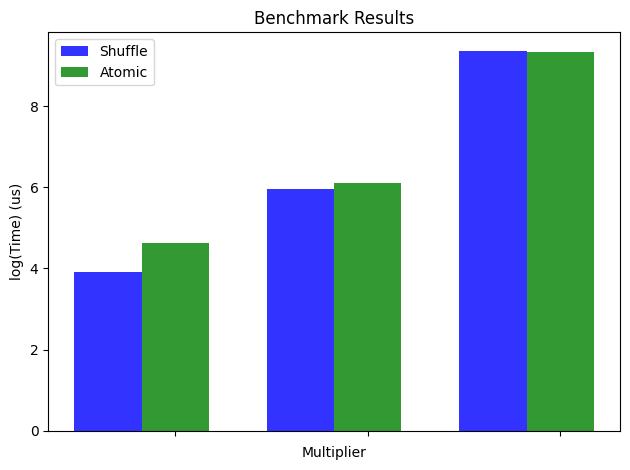

In [17]:
benchmark_shuffle = benchmark[benchmark['multiplier'] == "ShuffleSingleWarpMultiplier"]
benchmark_shuffle = benchmark_shuffle[benchmark_shuffle['n'] == 10000]
benchmark_shuffle['log_time'] = np.log(benchmark_shuffle['time_us'])
benchmark_atomic = benchmark[benchmark['multiplier'] == "AtomicSingleWarpMultiplier"]
benchmark_atomic = benchmark_atomic[benchmark_atomic['n'] == 10000]
benchmark_atomic['log_time'] = np.log(benchmark_atomic['time_us'])

columns = ["m", "time_us"]

print(benchmark_shuffle[columns])
print(benchmark_atomic[columns])

fig, ax = plt.subplots()
index = np.arange(3)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, benchmark_shuffle['log_time'], bar_width,
                    alpha=opacity,
                    color='b',
                    label='Shuffle')

rects2 = plt.bar(index + bar_width, benchmark_atomic['log_time'], bar_width,
                    alpha=opacity,
                    color='g',
                    label='Atomic')

plt.xlabel('Multiplier')
plt.ylabel('log(Time) (us)')
plt.title('Benchmark Results')
plt.xticks(index + bar_width, (''))
plt.legend()

plt.tight_layout()
plt.show()

## Wide Matrix Optimization

The purpose of the `WideMatrixMultiplier` is to be efficient when computing with matrices of size `10 x 10^n` for `n >> 1`. We ran these experiments separately, and we can see the results of comparing this for matrices of size $10 

## Single vs Multiple Warps

As seen by the multipliers, we wanted to determine whether using single or multiple warps to process a single row of input data would yield a speedup.